In [111]:
import sys
sys.path.insert(0, "../")

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import flax.linen as nn
from matplotlib import pyplot as plt
import module.util as util
import optax
from tqdm import tqdm

import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils import data
from jax.tree_util import tree_map
import numpy as np
from functools import partial

In [112]:
key = jax.random.PRNGKey(0)

## IDEA
We're trying to first build a variational autoencoder to learn the MNIST digits distribution and thus getting a feeling for a good model architecture.
Defining the latent space of $z \in Z$ dimension to be $n$, the decoder to be a gaussian with mean $\xi(z)$ and fixed variance for each component $\phi$, taking $\phi$ small and the encoder to be a gaussian of mean $\mu(x)$ and unit variance the loss function becomes:

$$
L = \mathbb{E}_{x \sim \mathrm{data}} \mathbb{E}_{z \sim q(z|x)} \left[ \frac{1}{2}\frac{||x - \xi(z)||^2}{\phi^2} + \frac{1}{2} ||\mu(x)||^2 \right]
$$

## DATA

In [113]:
def numpy_collate(batch):
  return tree_map(np.asarray, data.default_collate(batch))

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.array(pic)
  
mnist_dataset = datasets.MNIST('../data', download=True, transform=FlattenAndCast())
training_generator = NumpyLoader(mnist_dataset, batch_size=60000, num_workers=0)
dataset = next(iter(training_generator))[0]
data_std = jnp.max(jnp.std(dataset, axis = 0))
data_mean = jnp.mean(dataset, axis = 0)
dataset = (dataset - data_mean) / data_std

space_dim = (28, 28)

In [114]:
def get_samples(key, N = 1000):
    choice = jax.random.choice(key, jnp.arange(len(dataset)), (N,))
    return dataset[choice]

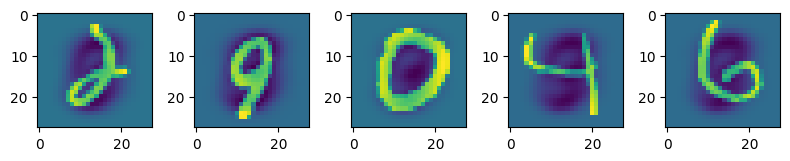

In [115]:
N = 5
samples = get_samples(key, N)
f, ax = plt.subplots(1, N, figsize = (8,4 ))
for i in range(N):
    ax[i].imshow(samples[i])

f.tight_layout()

In [127]:
act = lambda x: nn.softplus(x)
latent_dim: int = 64 # Dimension of the latent space

class Encoder(nn.Module):
    @nn.compact
    def __call__(self, x):

        # incorporate channel
        x = jnp.reshape(x, (x.shape[0], -1))

        x = nn.Dense(256)(x)
        x = act(x)

        x = nn.Dense(2*latent_dim)(x)
        x = act(x)

        return x

class Decoder(nn.Module):
    @nn.compact
    def __call__(self, x):

        x = nn.Dense(256)(x)
        x = act(x)

        x = nn.Dense(28*28)(x)
        x = act(x)

        x = jnp.reshape(x, (x.shape[0], 28, 28))
        return x

In [128]:
encoder = Encoder()
decoder = Decoder()
encoder_param = encoder.init(key, jnp.empty((1,) + space_dim))
decoder_param = decoder.init(key, jnp.empty((1, latent_dim)))

In [129]:
def calc_loss(key, encoder_param, decoder_param, N_samples, phi):
    samples = get_samples(key, N_samples)
    mu_logvar = encoder.apply(encoder_param, samples)
    mu = mu_logvar[:,:latent_dim]
    logvar = mu_logvar[:, latent_dim:]
    sigma = jnp.exp(logvar/2)

    key, _ = jax.random.split(key)
    z = jax.random.normal(key, shape = (N_samples, latent_dim))*sigma + mu

    xi = decoder.apply(decoder_param, z)

    reconstruction = jnp.sum((samples - xi)**2, axis = (-1,-2)) / 2 / phi**2
    regularisation = -jnp.sum(1 + logvar - mu**2 - sigma**2, axis = -1)/2

    return jnp.mean(reconstruction + regularisation)

@jax.jit
def grad_loss(key, encoder_param, decoder_param):
    l = lambda encoder_param, decoder_param: calc_loss(key, encoder_param, decoder_param, N_samples = 100, phi = 1e-2)
    loss, grad_fun = jax.vjp(l, encoder_param, decoder_param)
    return loss, grad_fun(jnp.array(1.))

In [130]:
losses = []

In [131]:
optimiser = optax.adam(1e-4)
opt_state = optimiser.init((encoder_param, decoder_param))

In [135]:
for i in tqdm(range(5000)):
    key, _ = jax.random.split(key)

    loss, grad = grad_loss(key, encoder_param, decoder_param)
    losses.append(loss)

    updates, opt_state = optimiser.update(grad, opt_state)
    (encoder_param, decoder_param) = optax.apply_updates((encoder_param, decoder_param), updates)

100%|██████████| 5000/5000 [01:18<00:00, 63.36it/s]


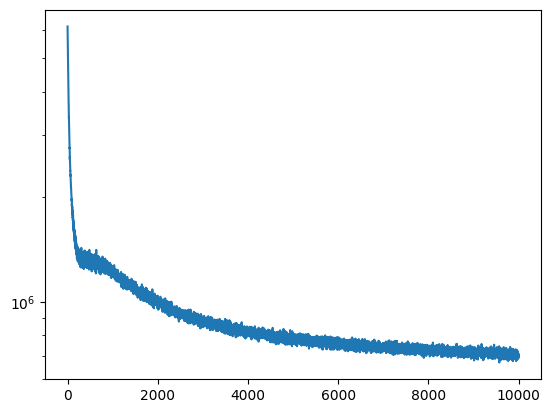

In [136]:
plt.plot(jnp.array(losses))
plt.yscale("log")

### SAMPLE

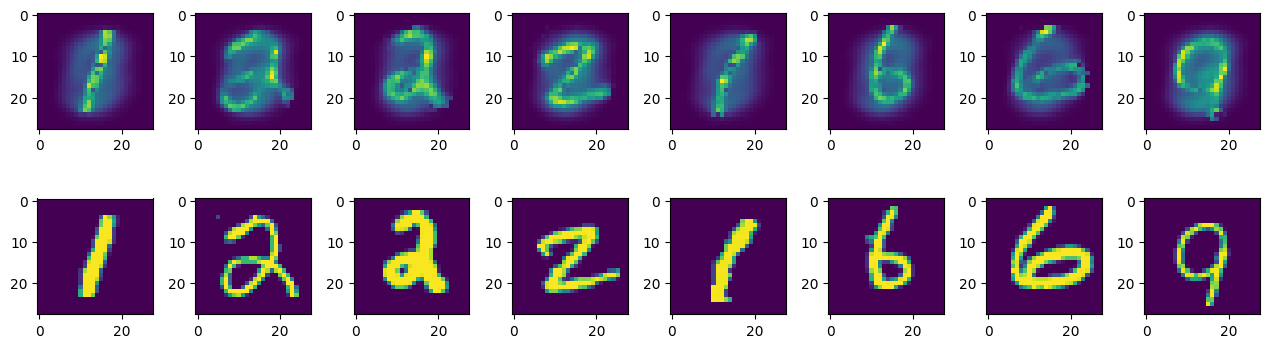

In [137]:
N = 8
key, _ = jax.random.split(key)
samples = get_samples(key, N)
mu_logvar = encoder.apply(encoder_param, samples)
mu = mu_logvar[:,:latent_dim]
logvar = mu_logvar[:, latent_dim:]
sigma = jnp.exp(logvar/2)

key, _ = jax.random.split(key)
z = jax.random.normal(key, shape = (N, latent_dim))*sigma + mu

x = decoder.apply(decoder_param, z)

f, ax = plt.subplots(2, N, figsize = (N*1.6, 4))
for i in range(N):
    ax[0, i].imshow(x[i]*data_std + data_mean)
    ax[1, i].imshow(samples[i]*data_std+data_mean)

f.tight_layout()

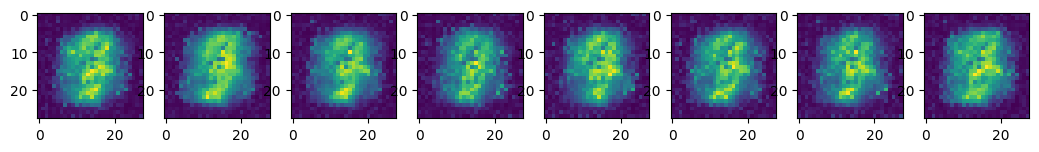

In [160]:
key, _ = jax.random.split(key)
z = jax.random.normal(key, (N, latent_dim))
x = decoder.apply(decoder_param, z)

f, ax = plt.subplots(1, N, figsize = (N*1.6, 4))
for i in range(N):
    ax[i].imshow(x[i]*data_std + data_mean)

---